In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd ../content/gdrive/MyDrive/COMP7404/ecg-view-II-machine-learning
! git pull

Mounted at /content/gdrive
/content/gdrive/MyDrive/COMP7404/ecg-view-II-machine-learning
Already up to date.


# RNN Training

From our paper on "Explainable Prediction of Acute Myocardial Infarction using Machine Learning and Shapley Values"

In [ ]:
# Import libraries 
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, GRU, LSTM, Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, GlobalAveragePooling2D,\
    concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers, backend, initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Ones, Zeros

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn import preprocessing
from sklearn import metrics

import time
import gc

import pandas as pd
import numpy as np
import pylab as plt
import tensorflow as tf
from numpy import loadtxt
from numpy import savetxt
from tensorflow.python.framework import ops
print(tf.__version__)

# Visualization Libraries
import seaborn as sns

# Size of matplotlib histogram bins
bin_size = 20

2.8.2


In [ ]:

!pip install keras.utils

# Loading Data

In [ ]:
! pwd 

/content/gdrive/MyDrive/COMP7404/ecg-view-II-machine-learning


In [ ]:
# Load data
train = loadtxt('train.csv', delimiter=',')
test = loadtxt('test.csv', delimiter=',')

# Split array
train_x = train[:,:11]
test_x = test[:,:11]
train_y = train[:,11]
test_y = test[:,11]

In [ ]:
# Check the new distribution in the training and testing sets
unique, counts = np.unique(train_y, return_counts=True)
dict(zip(unique, counts))

{0.0: 275553, 1.0: 137748}

In [ ]:
unique, counts = np.unique(test_y, return_counts=True)
dict(zip(unique, counts))

{0.0: 68865, 1.0: 34461}

# Model Definition + Training

In [ ]:
start = time.clock() 

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'eps': self.eps,
            'gamma': self.gamma,
            'beta': self.beta
        })
        return config

layer_size1 = 12
layer_size2 = 10
layer_size3 = 7
layer_size4 = 5
layer_size5 = 4
layer_size6 = 3
timesteps = 1 # static data
data_dim = 11

X_train = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
X_test = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
train_y = to_categorical(train_y)
alpha = 0.001

model = Sequential()
model.add(GRU(layer_size1, return_sequences=True, input_shape=(timesteps, data_dim)))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=alpha))
model.add(GRU(layer_size2, return_sequences=True))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=alpha))
model.add(GRU(layer_size3, return_sequences=True))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=alpha))
model.add(GRU(layer_size4, return_sequences=True))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=alpha))
model.add(GRU(layer_size5, return_sequences=True))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=alpha))
model.add(GRU(layer_size6, return_sequences=False))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=alpha))
model.add(Dense(2, activation='softmax'))


opt = tf.keras.optimizers.Adam(alpha)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Set early stopping based on accuracy. It stops after 10 consecutive epochs of no accuracy improvement.
early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# Reduce learning rate based on accuracy. It reduces the rate after 7 consecutive epochs of no accuracy improvement.
redonplat = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=7, verbose=0)

callbacks_list = [early, redonplat]

# Train the model
history = model.fit(X_train, train_y, epochs=50, verbose=0, callbacks=callbacks_list, validation_split=0.1) ###change epoch number
end = time.clock()
print("Time for training: {}mins ".format((end-start)/60)) 

# Save the model
tf.saved_model.save(model, "/rnn_ecgview.h5")
model.save("rnn_ecgview.h5")

In [ ]:
tf.saved_model.save(model, "/rnn_ecgview.h5")

INFO:tensorflow:Assets written to: /rnn_ecgview.h5/assets


INFO:tensorflow:Assets written to: /rnn_ecgview.h5/assets


In [ ]:
model.save_weights("rnn_ecgview.h5")
model.load_weights("rnn_ecgview.h5")


In [ ]:
history.history

Model Accuracy Plot

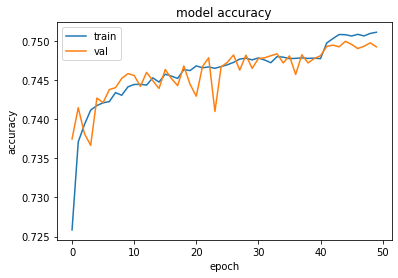

In [ ]:
# Plot model accuracy evolution
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model Loss plot

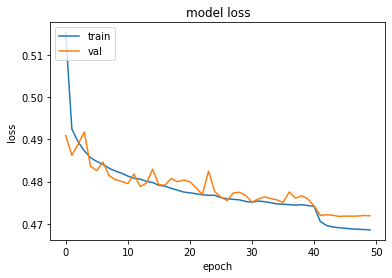

In [ ]:
# Plot model loss evolution
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation

In [ ]:
# Test the model
start = time.clock() 
pred_test = model.predict(X_test)
end = time.clock()
pred_test = np.argmax(pred_test, axis=-1)
print("Time for prediction: {} ".format((end-start))) 

# Get f1 score 
f1 = f1_score(test_y, pred_test, average="macro")
print("Test f1 score : %s "% f1)

# Get ROC AUC score 
roc = roc_auc_score(test_y, pred_test)
print("Test ROC AUC Score : %s "% roc)

# Get the accuracy
acc = accuracy_score(test_y, pred_test)
print("Test accuracy score : %s "% acc)

In [ ]:

# Import libraries
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, GRU, LSTM, Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers, backend, initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Ones, Zeros
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn import preprocessing

import time
import gc

import pandas as pd
import numpy as np
import pylab as plt
import tensorflow as tf
from numpy import loadtxt
from numpy import savetxt
from tensorflow.python.framework import ops
print(tf.__version__)

# Visualization Libraries
import seaborn as sns

2.8.2


In [ ]:

model = model
# model = load_model('rnn_ecgview.h5', custom_objects={'LayerNormalization': LayerNormalization})
model.summary()

# Test the model
start = time.clock() 
pred_test = model.predict(X_test)
end = time.clock()
pred_test = np.argmax(pred_test, axis=-1)
print("Time for prediction: {} ".format((end-start))) 

# Get f1 score 
f1 = f1_score(test_y, pred_test, average="macro")
print("Test f1 score : %s "% f1)

# Get ROC AUC score
roc = roc_auc_score(test_y, pred_test)
print("Test ROC AUC Score : %s "% roc)

# Get the accuracy
acc = accuracy_score(test_y, pred_test)
print("Test accuracy score : %s "% acc)

# Get the specificity
tn, fp, fn, tp = confusion_matrix(test_y, pred_test).ravel()
specificity = tn / (tn+fp)
print("Specificity : %s "% specificity)

# Get the sensitivity
sensitivity= tp / (tp+fn)
print("Sensitivity: %s "% sensitivity)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 12)             900       
                                                                 
 layer_normalization (LayerN  (None, 1, 12)            24        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 12)             0         
                                                                 
 gru_1 (GRU)                 (None, 1, 10)             720       
                                                                 
 layer_normalization_1 (Laye  (None, 1, 10)            20        
 rNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 10)             0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


Time for prediction: 16.376044000000547 
Test f1 score : 0.7099702256675042 
Test ROC AUC Score : 0.7065099574237356 
Test accuracy score : 0.7467433172676771 
Specificity : 0.8273433529369055 
Sensitivity: 0.5856765619105656 


## Evaluation - Confusion Matrix

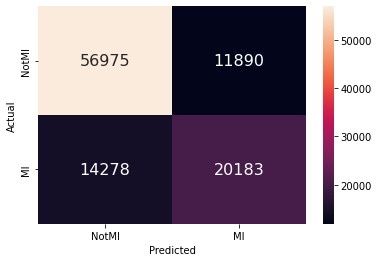

In [ ]:

# Confusion matrix
confusion = confusion_matrix(test_y, pred_test)
sns.heatmap(data=confusion, annot=True, xticklabels=["NotMI", "MI"], yticklabels=["NotMI", "MI"], fmt = "d", annot_kws={"fontsize":16})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.yticks(va="center")
plt.show()